In [1]:
import numpy as np
import matplotlib.pyplot as plt


beta = 0.5; shift = 0;
samplefixed = 100000
samplerandom = 200000

Defino el rango del mapeo cuando los parámetros están en un rango definido y cuando son aleatorios

In [3]:
# period: 1D-1Y
Tfixed = np.linspace(0.004,1,100)
Trandom = np.random.random_sample(samplerandom) * (1 - 0.004) + 0.004

# parameters
alphafixed = np.linspace(0.05,0.5,10)
alpharandom = np.random.random_sample(samplerandom) * 0.45 + 0.05

rhofixed = np.linspace(-0.9, 0.9, 10)
rhorandom = np.random.random_sample(samplerandom) * 1.8 - 0.9

# volatility of volatility
nuauxfixed = np.linspace(0.05,4.0,10)
nuauxrandom = np.random.random_sample(samplerandom) * (4.0 - 0.05) + 0.05

def nu(nuaux,T):
    Taux = 30 / 365
    nu = nuaux * np.sqrt(Taux/T)
    return nu

Taux = 30 / 365
nurandom = nuauxrandom * np.sqrt(Taux/Trandom)

## dinamical strike
nstrike = np.linspace(-3.5,3.5,10)

def K(alpha,rho,nu,T,n_s):
    naux = 1.5  # predetermined and defined in the article
    sigma_T = alpha * np.exp(- 0.5 * nu * nu * T + nu * naux * np.sqrt(T))  
    F0 = 0.01   # predetermined, does not appear in the paper
    term1 = - 0.5 * (alpha/nu) ** 2 * (np.exp(nu * nu * T) -1)
    term2 = rho * (sigma_T - alpha) / nu
    term3 = n_s * alpha * np.sqrt(np.exp(nu * nu * T) - 1) / nu
    k = F0 * np.exp(term1 + term2 + term3)
    return k

Genero los conjuntos de datos según se describe en el artículo, $10^5$ prefijados y $2\cdot 10^5$ con valores aleatorios de los parámetros

In [4]:
### FIXED SET OF DATA ###
X_fixed = []
for t in Tfixed: # 100 iterations
    for i in alphafixed:    #10 iterations for init vol
        for j in rhofixed:      # 10 iterations for rho
            nufix = nu(nuauxfixed,t)
            xvector = []
            for u in range(len(nufix)):     # 10 iterations for vol of vol (nu)
                K_range = []
                for k in range(len(nstrike)):
                    K_din = K(i,j,nufix[u],t,nstrike[k])
                    K_range.append(K_din)
                xvector = np.hstack((K_range, t, i, j, nufix[u]))
                X_fixed.append(xvector)    
X_fixed = np.matrix(X_fixed)
    
### RANDOM SET OF DATA ###
X_random = []
for i in range(len(Trandom)):
    K_range = []
    for j in range(len(nstrike)):
        aux = K(alpharandom[i],rhorandom[i],nurandom[i],Trandom[i],nstrike[j])
        K_range.append(aux)
    xvector = np.hstack((K_range, Trandom[i],alpharandom[i],rhorandom[i],nurandom[i]))
    X_random.append(xvector)
X_random = np.matrix(X_random)

X = np.vstack((X_fixed,X_random))

In [6]:
### OBTAIN SABR VOLATILIES (NORMAL) ###
import SABRnormal
volatility = []
for i in range(len(X)):
    aux2 = []
    for j in range(len(nstrike)):
        aux = SABRnormal.normal_vol(X[i,j],0.01,X[i,10],X[i,11],beta,X[i,12],X[i,13],shift)
        aux2.append(aux)
    volatility.append(aux2)
volatility = np.matrix(volatility)

### PREPARE DATA FOR NN ###
from sklearn import preprocessing
X_mean = X.mean(axis = 0); X_std = X.std(axis = 0)
X_norm = preprocessing.scale(X)

X_train = X_norm[:250000,:]; X_test = X_norm[250000:,:]
y_train = volatility[:250000,:]; y_test = volatility[250000:,:]

Defino y entreno la red neuronal, con 4 capas con 64 neuronas cada una y función de activación elu. El input de la primera capa son los 10 strikes, T y los 3 parámetros del SABR

In [ ]:
### NEURAL NETWORK TRAINING ###

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

model = Sequential()
#model.add(Dense(1000, activation='elu', input_dim = 14, kernel_initializer='he_uniform'))
#model.add(Dense(10))
model.add(Dense(64, activation='elu', input_dim = 14, kernel_initializer='he_uniform'))
model.add(Dense(64, activation='elu',  kernel_initializer='he_uniform'))
model.add(Dense(64, activation='elu',  kernel_initializer='he_uniform'))
model.add(Dense(64, activation='elu',  kernel_initializer='he_uniform'))
model.add(Dense(10))

sgd = keras.optimizers.Adam(lr=0.001)
model.compile(loss=keras.losses.mean_squared_error,
              optimizer=sgd,
              metrics=['mae', 'accuracy'])

epochs = 500
batch_size = 128
earlystop = EarlyStopping(monitor = 'val_loss', patience=40, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=15, cooldown = 1, min_lr= 0.000009, verbose = 1)

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, y_test),
          callbacks = [reduce_lr, earlystop]
          )

model.save_weights('mcgee0505normelu64_4.h5')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 250000 samples, validate on 50000 samples
Epoch 1/500
250000/250000 [==============================] - 7s 27us/step - loss: 0.0185 - mean_absolute_error: 0.0488 - acc: 0.1550 - val_loss: 5.0128e-04 - val_mean_absolute_error: 0.0174 - val_acc: 0.2469
Epoch 2/500
250000/250000 [==============================] - 6s 25us/step - loss: 3.1294e-04 - mean_absolute_error: 0.0133 - acc: 0.2390 - val_loss: 1.7753e-04 - val_mean_absolute_error: 0.0102 - val_acc: 0.2737
Epoch 3/500
250000/250000 [==============================] - 6s 25us/step - loss: 1.3197e-04 - mean_absolute_error: 0.0085 - acc: 0.3234 - val_loss: 7.3472e-05 - val_mean_absolute_error: 0.0065 - val_acc: 0.3502
Epoch 4/500
250000/250000 [==============================] - 6s 25us/step - loss: 6.5035e-05 - mean_absolute_error: 0.0061 - acc: 0.3894 - val_loss: 4.4019e-05 - val_mean_absolute_error: 0.0050 - v

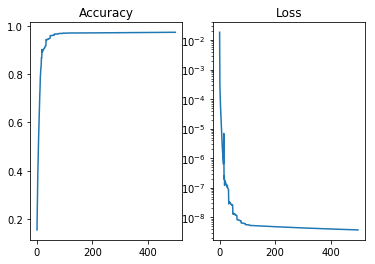

In [12]:
### METRICS PLOTS ###
plt.subplot(121)
plt.plot(history.history['acc']); plt.title('Accuracy')
plt.subplot(122)
plt.plot(history.history['loss']); plt.yscale('log'); plt.title('Loss')

### TEST WINDOW ###
#alpha = 0.2; rho = 0.4; Nu = 0.5; T = 1.5
row = -1000
Ktest = np.squeeze(X[row,0:10].tolist())
T = X[row,10]; alpha = X[row,11]; rho = X[row,12]; Nu = X[row,13]
vol = []
for i in range(len(Ktest)):
    aux = SABRnormal.normal_vol(Ktest[i],0.01,T,alpha,beta,rho,Nu,shift)
    vol.append(aux)

x_test = X_norm[row,:]
x_test = x_test.reshape(1,-1)
volNN = model.predict(x_test)

from scipy import interpolate
K_range = np.linspace(min(Ktest), max(Ktest),100)

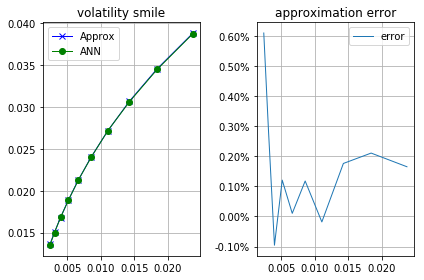

In [13]:
# Plots only the points obtained through the NN #
plt.figure()
plt.subplot(121)
plt.plot(Ktest,vol, color = 'blue', marker = 'x', linewidth = 1.0);
plt.plot(Ktest,np.squeeze(volNN.tolist()), color = 'green', marker = 'o', linewidth = 1.0);
plt.grid(True); plt.legend(['Approx','ANN']); plt.title('volatility smile')

plt.subplot(122)
plt.plot(Ktest, (vol - np.squeeze(volNN))/vol, linewidth = 1.0);
plt.grid(True); plt.legend(['error']); plt.title('approximation error')
plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.tight_layout()

McGee realiza una interpolación cúbica de las 10 volatilidades obtenidas

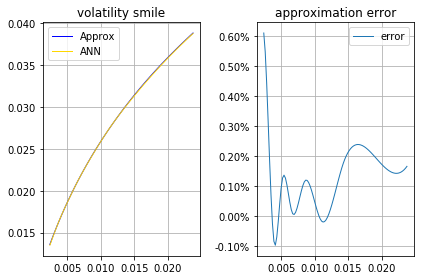

In [14]:
# Plots the cubic spline #

spl = interpolate.splrep(Ktest,vol, k = 3)
vol_spline = interpolate.splev(K_range,spl, der = 0)
spl2 = interpolate.splrep(Ktest,np.squeeze(volNN.tolist()), k = 3)
volNN_spline = interpolate.splev(K_range,spl2, der = 0)

plt.figure()
plt.subplot(121)
plt.plot(K_range,vol_spline, color = 'blue', linewidth = 1.0); 
plt.plot(K_range,volNN_spline, color = 'gold', linewidth = 1.0);
plt.grid(True); plt.legend(['Approx','ANN']); plt.title('volatility smile')
#plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
#plt.gca().set_xticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_xticks()]) #K as %

plt.subplot(122)
plt.plot(K_range, (vol_spline - volNN_spline)/vol_spline, linewidth = 1.0);
plt.grid(True); plt.legend(['error']); plt.title('approximation error')
plt.gca().set_yticklabels(['{:.2f}%'.format(x*100) for x in plt.gca().get_yticks()]) #vol as %
plt.tight_layout()